In [2]:
import DevelopingModels.ProductionModels.src.get_data as get_data
import DevelopingModels.ProductionModels.src.load_data as load

import pandas as pd
import seaborn as sns
from pylab import rcParams
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

In [6]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

"""
init_notebook_mode(connected=True)

openValue = go.Scatter( x = df.date, y = df.open, name = 'openValue')
closeValues = go.Scatter( x = df.date, y = df.close, name = 'closeValues')
highValue = go.Scatter( x = df.date, y = df.high, name = 'highValue')

iplot([openValue, highValue])



trace = go.Candlestick(x=df.date,
                       open=df.open,
                       high=df.high,
                       low=df.low,
                       close=df.close,
                      text = df.columns)
layout = {
    'title': 'Candlestick BTC data',
    'yaxis': {'title': 'BTC-USD'},    
}
candleData = [trace]

fig = dict(data=candleData, layout=layout)

iplot(fig)

"""

print()

In [9]:
df = get_data.get_data_frame()

# Тест Дикки-Фуллера

Проверка стационарности временного ряда https://wikipedia.org/wiki/Тест_Дики_—_Фуллера

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



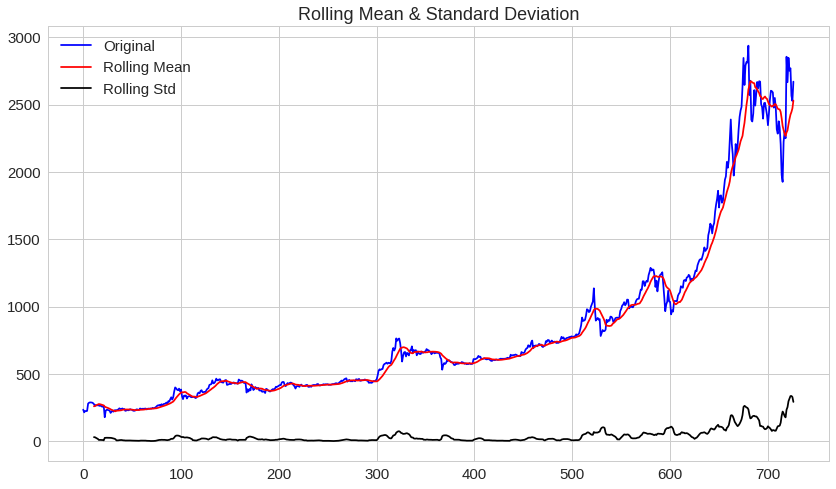

In [12]:
from statsmodels.tsa.stattools import adfuller

timeseries = df.close

rolmean = pd.rolling_mean(timeseries, window=12)
rolstd = pd.rolling_std(timeseries, window=12)

orig = plt.plot(timeseries, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')

plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [15]:
print ('Results of Dickey-Fuller Test:')

dftest = adfuller(timeseries, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   1.095616
p-value                          0.995179
#Lags Used                      19.000000
Number of Observations Used    707.000000
Critical Value (1%)             -3.439633
Critical Value (5%)             -2.865637
Critical Value (10%)            -2.568952
dtype: float64


/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()



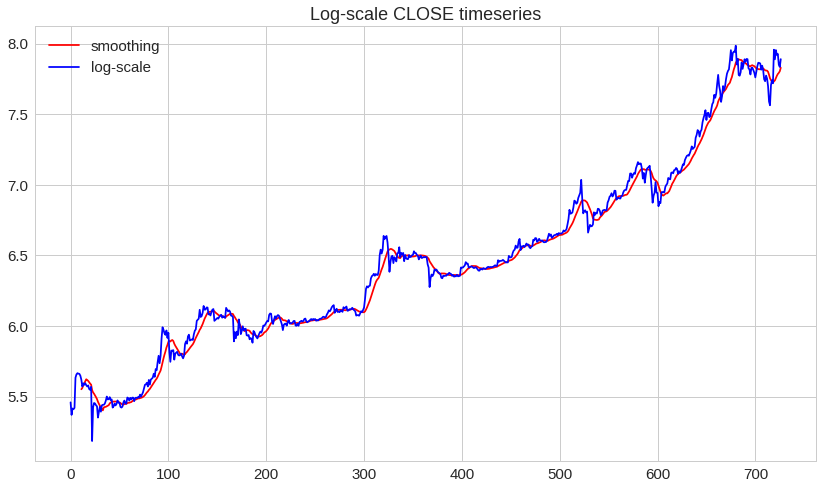

In [16]:
log_scale = np.log(timeseries)
moving_avg = pd.rolling_mean(log_scale, 12)

plt.title('Log-scale CLOSE timeseries')
plt.plot(moving_avg, label = 'smoothing',color='red')
plt.plot(log_scale, label = 'log-scale', color = 'blue')
plt.legend()
plt.show()

# Trend and season


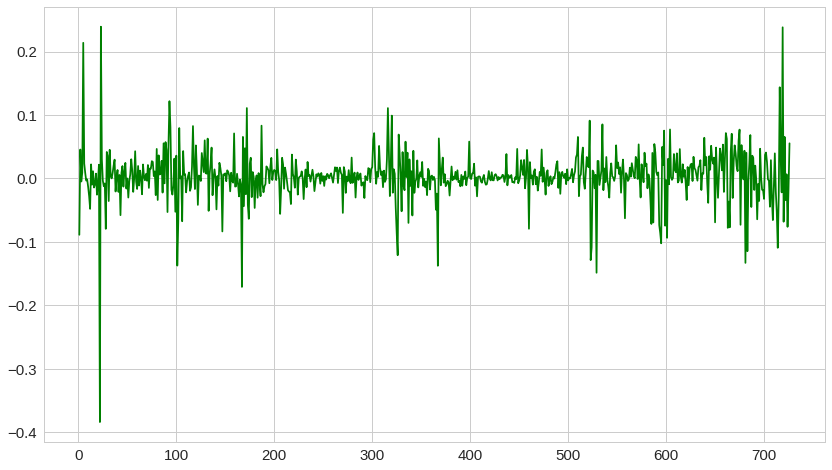

In [18]:
ts_log_diff = log_scale - log_scale.shift(1)
plt.plot(ts_log_diff, color = 'green')
plt.show()

## Statmodels tools for time-series analisys

http://www.statsmodels.org/dev/tsa.html

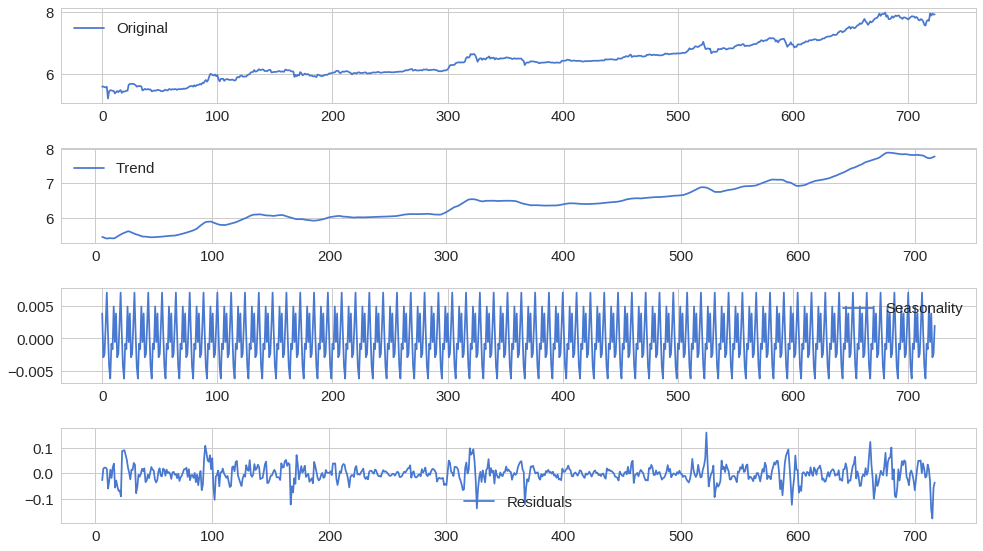

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(log_scale.values, freq=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(log_scale.values, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Проверим  корреляцию Объема и цены закрытия


/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning:

pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=5,min_periods=0,adjust=True,ignore_na=False).mean()

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning:

pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=5,min_periods=0,adjust=True,ignore_na=False).mean()



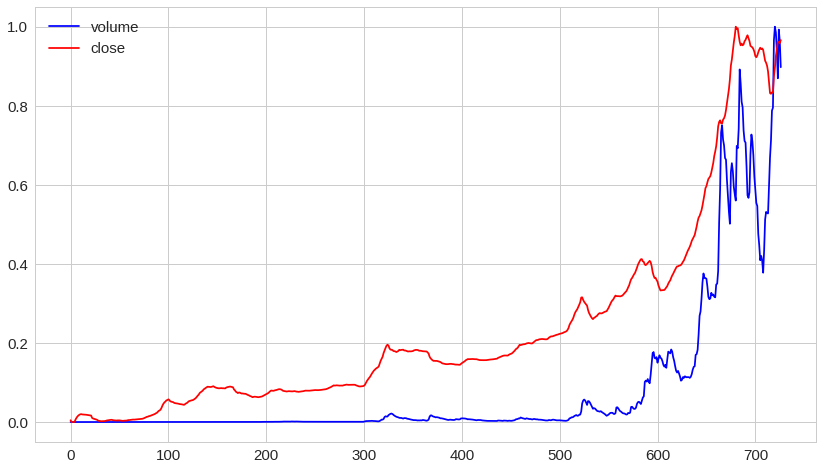

In [41]:
from sklearn.preprocessing import MinMaxScaler

df = get_data.get_data_frame()

v = df.volume
c = df.close

SMOOTH_STEP = 5

v = pd.ewma(v, SMOOTH_STEP)
c = pd.ewma(c, SMOOTH_STEP)

v_scaler = MinMaxScaler()
c_scaler = MinMaxScaler()

v_v = v_scaler.fit_transform(v.values.reshape(-1, 1))
c_v = c_scaler.fit_transform(c.values.reshape(-1, 1))
    
    
plt.plot(v_v, color = 'blue', label = 'volume')
plt.plot(c_v, color = 'red', label = 'close')
plt.legend()
plt.show()


